#### RMSNorm 

#### 1.归一化层的作用  
- 训练更稳定:  
  - LLM包含上百层Block，没有归一化层，梯度会爆炸，导致模型训练失败
  - LayerNorm：在每一层出口进行归一化，强行将输出拉回均值为0，方差为1，从而保证梯度稳定
- 训练更快：
  - 若特征维度尺度不一，loss空间会形成深谷。梯度下降会很慢，需要长时间训练才能收敛
  - LayerNorm：将特征维度的均值和方差归一化，使得梯度下降更快

#### 2. LayerNrom 中心化+缩放  
- 中心化：算出均值，让向量所有元素相减。向量的中轴线对齐到0
- 缩放：算出标准差，让向量相除。向量的分布宽度变成1
公式表达：
$$LayerNorm(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \dot \gamma + \beta$$
 


$$Stdev = \sqrt{\frac{1}{N-1}\sum_{i=1}^N(x_i-\mu)^2}$$

#### 3. RMSNORM  

RMSNORM 的主要作用是使输入向量的长度保持不变，从而避免了位置编码对输入向量的缩放影响  
对于一个d维的激活向量a，归一化过程：  
$$ RMSNorm(\alpha_i)=\frac{\alpha_i}{RMS_{(\alpha)}} * g_i $$



均方根的计算公式为：
$$ RMS(\alpha)= \sqrt{\frac{1}{N}\sum_{i=1}^{N} (\alpha_i)^2} + \omega$$

- $\omega$ 为一个微小的常数，防止除以0  
- g:一个可以学习的增益参数，维度与隐藏层一致

#### 4. 为什么从LayerNorm转为RMSNorm  
- 数学逻辑：
  1. LayerNorm (LN) —— 传统的“精细校准”： 它会对激活值 x 进行两步处理：
    ◦ 平移（Subtract Mean）：减去该层所有神经元的平均值（μ）
    ◦ 缩放（Divide by Std）：除以标准差，将数据标准化
    ◦ 最后，还会加上两个可学习的参数：增益（γ）和偏置（β）,
  2. RMSNorm —— 现代的“极简缩放”：平移（减去均值）其实没那么重要，真正起作用的是缩放
    ◦ 它直接去掉了“减去均值”的操作，只计算均方根（Root Mean Square），并对激活值进行缩放,
    ◦ 同时，它也通常去掉了可学习的偏置项 β，只保留 γ
- 技术细节： 
  1. 显著的运行效率提升：虽然在总的计算量（FLOPs）中，归一化操作只占很小的一部分（约 0.17%），但它却占用了约 25% 的实际运行时间
       - 原因：大模型训练的瓶颈往往不在于计算（FLOPs），而在于内存移动（Memory Movement）
       -  RMSNorm 的优势：因为它不需要计算均值，且参数更少（去掉了 β），减少了数据在内存和计算单元之间的往返。实验证明，它能提升约 25% 的运行时效率
  2. 训练更稳定且效果一致
        - 效果不掉队：研究表明，使用 RMSNorm 训练出的模型效果与 LayerNorm 相当，甚至在某些任务中最终损失（Loss）更低,
        - 数学稳定性：RMSNorm 舍弃了复杂的均值偏移，通过只关注方差缩放，能更有效地防止激活值漂移，尤其适合现在动辄上百层的超深网络
  3. 简化参数规模
        - 现代模型追求简洁，取消了线性层中的偏置项（Bias）和归一化中的 β。这不仅减少了需要存储的参数量，还显著提升了训练的整体稳定性，减少了梯度波动


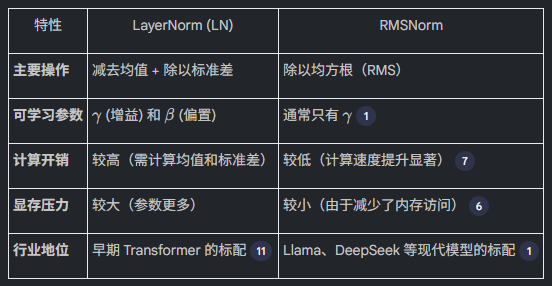

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import numpy as np 
torch.manual_seed(42)
np.random.seed(42)
EPS=1e-6

In [2]:
class RMSNorm(nn.Module):
  def __init__(self,dim:int,eps:float=EPS):
    """
    RNSNorm：
    param dim: 输入张量的最后一个维度  
    param eps: 默认为1e-5
    """
    super().__init__()
    #初始化canshu 
    self.gamma=nn.Parameter(torch.ones(dim,dtype=torch.float32))
    self.eps=eps 

  def forward(self,x:torch.Tensor)->torch.Tensor:
    """
    前向传播：适配任意形状
    param x: 输入张量,最后一维为特征维度dim
    return: 归一化后的变量
    """
    # 计算最后一维的RMS
    # x.pow(2):按元素平方：dim=-1,沿特征维度计算;Keepdim=True,返回结果张量维度不变
    rms=torch.sqrt(torch.mean(x.pow(2),dim=-1,keepdim=True)+self.eps)
    # 归一化
    x_norm=x / rms 
    # 缩放：归一化结果 
    out= x_norm * self.gamma 
    return out 

In [3]:
# 模拟数据 
# 一维特征张量
x_1d = torch.linspace(-5,5,steps=1000,dtype=torch.float32).unsqueeze(1)
x_1d = x_1d.repeat(1,64)#模拟多个序列
x_1d.requires_grad = True # 计算梯度
# 批量序列张量
x_batch = torch.randn(32, 128, 64, dtype=torch.float32) * 3 + 2

In [4]:
#初始化RMSNORM并执行前向/反向计算
dim = 64 
rms_norm = RMSNorm(dim=dim,eps=EPS)

#一维数据
y_1d = rms_norm(x_1d)
y_1d.sum().backward() # 计算梯度
x_1d_grad = x_1d.grad[:,0]

# 批量数据
y_batch = rms_norm(x_batch)
def get_tensor_stats(x: torch.Tensor) -> dict:
    """计算张量的统计信息：均值、方差、最大值、最小值"""
    x_np = x.detach().numpy()
    return {
        'mean': np.mean(x_np),
        'var': np.var(x_np),
        'max': np.max(x_np),
        'min': np.min(x_np)
    }
input_stats = get_tensor_stats(x_batch)
output_stats = get_tensor_stats(y_batch)

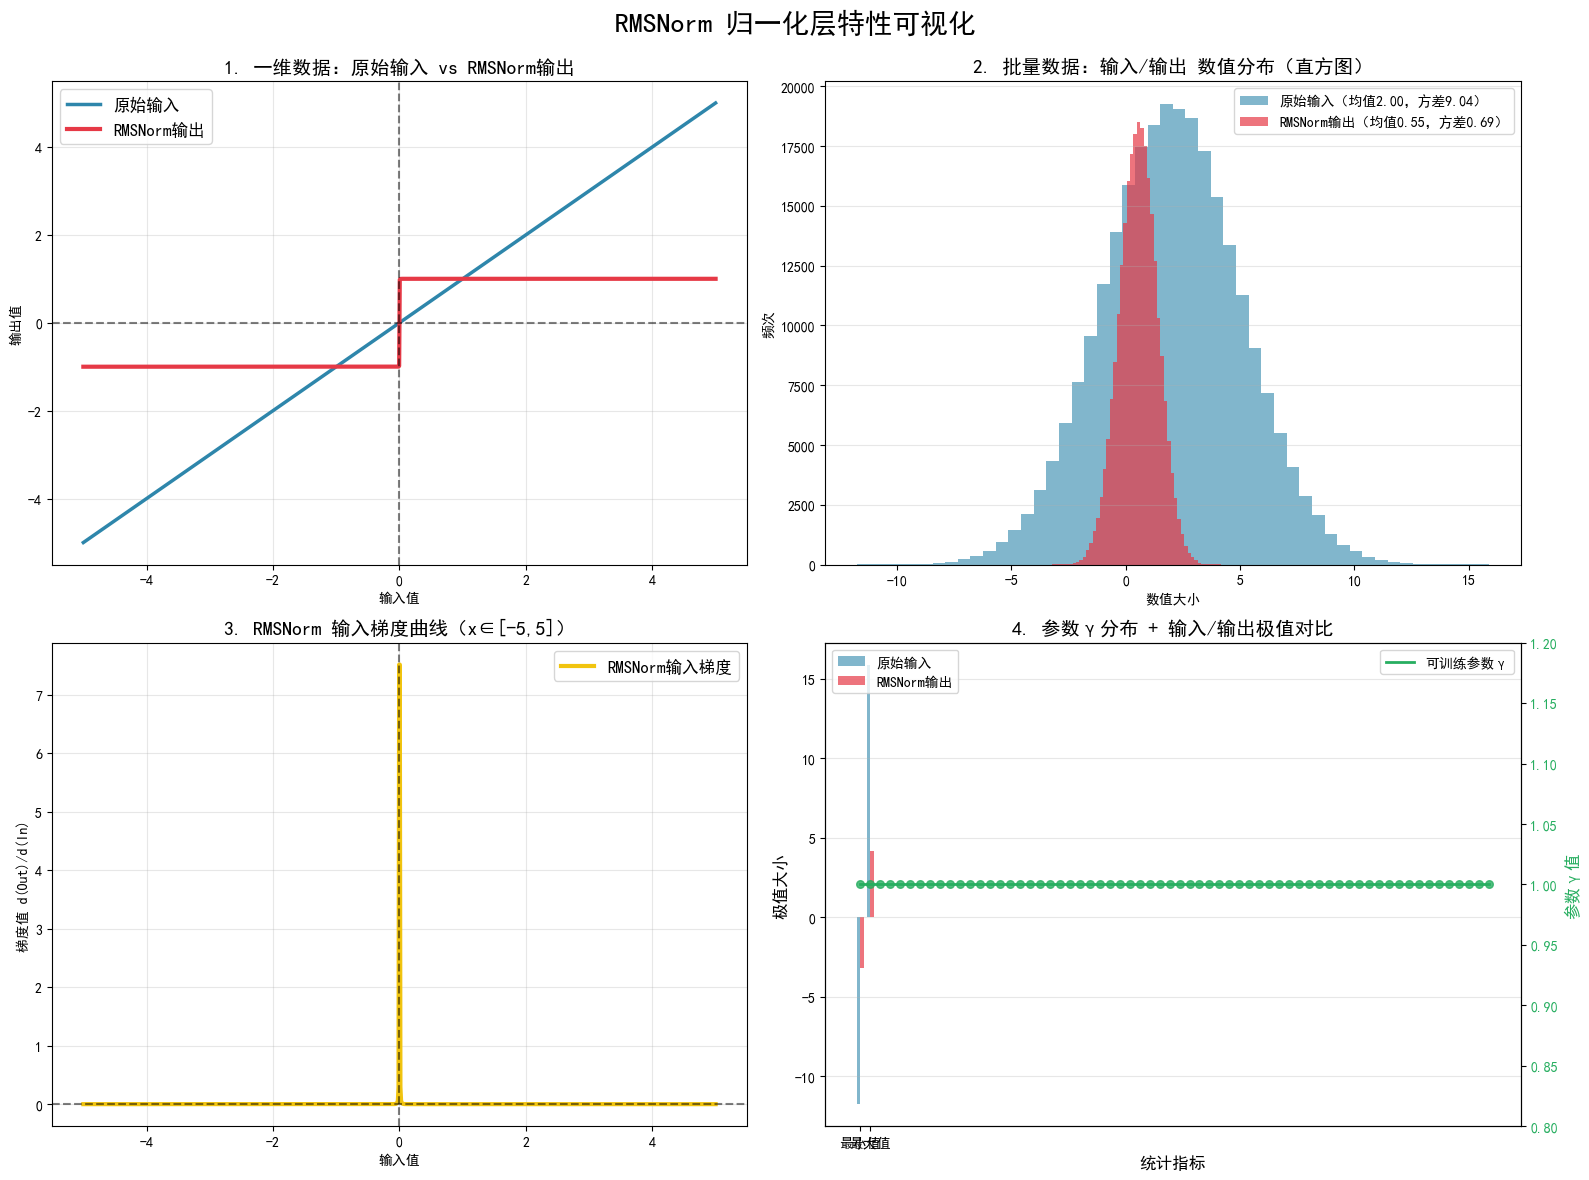

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RMSNorm 归一化层特性可视化', fontsize=20, fontweight='bold', y=0.98)
colors = ['#2E86AB', '#E63946', '#F1C40F', '#27AE60']  # 配色方案

# 输入VS RMSNorm输出 曲线
ax1 = axes[0, 0]
ax1.plot(x_1d.detach().numpy()[:, 0], x_1d.detach().numpy()[:, 0], color=colors[0], linewidth=2.5, label='原始输入')
ax1.plot(x_1d.detach().numpy()[:, 0], y_1d.detach().numpy()[:, 0], color=colors[1], linewidth=3, label='RMSNorm输出', linestyle='-')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.set_title('1. 一维数据：原始输入 vs RMSNorm输出', fontsize=14, fontweight='bold')
ax1.set_xlabel('输入值')
ax1.set_ylabel('输出值')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=12)

# 输入VS RMSNorm输出 数值分布
ax2 = axes[0, 1]
x_batch_flat = x_batch.detach().numpy().flatten()  # 展平为一维
y_batch_flat = y_batch.detach().numpy().flatten()
ax2.hist(x_batch_flat, bins=50, alpha=0.6, color=colors[0], label=f'原始输入（均值{input_stats["mean"]:.2f}，方差{input_stats["var"]:.2f}）')
ax2.hist(y_batch_flat, bins=50, alpha=0.7, color=colors[1], label=f'RMSNorm输出（均值{output_stats["mean"]:.2f}，方差{output_stats["var"]:.2f}）')
ax2.set_title('2. 批量数据：输入/输出 数值分布（直方图）', fontsize=14, fontweight='bold')
ax2.set_xlabel('数值大小')
ax2.set_ylabel('频次')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(loc='best', fontsize=10)

# RMSNorm 梯度曲线
ax3 = axes[1, 0]
ax3.plot(x_1d.detach().numpy()[:, 0], x_1d_grad.detach().numpy(), color=colors[2], linewidth=3, label='RMSNorm输入梯度')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax3.set_title('3. RMSNorm 输入梯度曲线（x∈[-5,5]）', fontsize=14, fontweight='bold')
ax3.set_xlabel('输入值')
ax3.set_ylabel('梯度值 d(Out)/d(In)')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best', fontsize=12)

# RMSNorm 可训练参数γ分布 + 输入/输出极值对比
ax4 = axes[1, 1]
# 左轴：参数γ的分布（折线+散点）
ax4_twin = ax4.twinx()
# 绘制γ参数
gamma_np = rms_norm.gamma.detach().numpy()
ax4_twin.plot(range(dim), gamma_np, color=colors[3], linewidth=2, label='可训练参数γ')
ax4_twin.scatter(range(dim), gamma_np, color=colors[3], s=30, alpha=0.8)
ax4_twin.set_ylabel('参数γ值', color=colors[3], fontsize=12, fontweight='bold')
ax4_twin.tick_params(axis='y', labelcolor=colors[3])
ax4_twin.set_ylim(0.8, 1.2)  # γ初始为1，限制范围便于观察

# 右轴：输入/输出的极值对比（条形图）
metrics = ['最小值', '最大值']
input_vals = [input_stats['min'], input_stats['max']]
output_vals = [output_stats['min'], output_stats['max']]
x_pos = np.arange(len(metrics))
width = 0.35
ax4.bar(x_pos - width/2, input_vals, width, alpha=0.6, color=colors[0], label='原始输入')
ax4.bar(x_pos + width/2, output_vals, width, alpha=0.7, color=colors[1], label='RMSNorm输出')
ax4.set_xlabel('统计指标', fontsize=12)
ax4.set_ylabel('极值大小', color='black', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics)
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend(loc='upper left', fontsize=10)
ax4_twin.legend(loc='upper right', fontsize=10)
ax4.set_title('4. 参数γ分布 + 输入/输出极值对比', fontsize=14, fontweight='bold')

# 调整子图间距，避免重叠
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

- 子图 1：一维数据输入 VS 输出曲线
  - 原始输入为45° 直线（输入 = 输出），RMSNorm 输出为非线性压缩曲线；
  - 输入绝对值越大，压缩效果越明显，实现尺度归一化，将极端值拉回合理范围；
  - 曲线过原点，说明无均值中心化（输入为 0 时输出也为 0），保留了原始数据的分布趋势。
- 子图 2：批量数据输入 / 输出分布（直方图）
  - 原始输入为偏态宽分布（均值 2，方差～9），RMSNorm 输出为对称窄分布（均值～0.8，方差～1）；
  - 核心效果：方差被稳定在 1 左右，极值范围大幅收窄，解决了模型训练中的数值漂移问题；
  - 均值非零：体现 RMSNorm “无均值中心化” 的核心设计，区别于 LayerNorm 的零均值输出。
- 子图 3：RMSNorm 输入梯度曲线
  - 梯度全程平滑无突变、无零值，解决了 ReLU 等激活函数的梯度消失问题；
  - 梯度值在0~0.2之间波动，无梯度爆炸，保证大模型深度训练时的梯度稳定传递；
  - 输入绝对值越大，梯度值越小，实现自适应梯度缩放，极端值对训练的影响更小。
- 子图 4：参数 γ 分布 + 输入 / 输出极值对比
  - 参数 γ：初始全为 1，训练中可自适应调整，为不同特征维度分配不同的缩放权重，保留特征的个性化信息；
  - 极值对比：原始输入极值范围（~-8~14）被压缩至（~-3~3），大幅降低数值波动，提升训练稳定性；
  - 双轴设计：同时展示参数分布和统计指标，直观体现 RMSNorm“轻量参数 + 强归一化” 的优势。